# Boosting

[Employee Dataset on Kaggle](https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## AdaBoost

AdaBoost (Adaptive Boosting) is an ensemble learning method based on the principle of **boosting** — combining multiple **weak learners** (typically shallow decision trees) trained **sequentially**, where each model focuses more on the samples that were misclassified by previous ones.

### 1. Weighted samples initialization

All training examples start with equal weights:

$$
w_i^{(1)} = \frac{1}{N}, \quad i = 1, 2, \dots, N
$$

where  

* $N$ — total number of training samples,  
* $w_i^{(t)}$ — weight of sample $i$ at iteration $t$.

### 2. Sequential model training

At each iteration $t$, a weak model $h_t(x)$ is trained to minimize the **weighted error**:

$$
\varepsilon_t =
\frac{\sum_{i=1}^{N} w_i^{(t)} \,\mathbf{1}\!\left(h_t(x_i) \neq y_i\right)}
{\sum_{i=1}^{N} w_i^{(t)}}
$$

where $\mathbf{1}(\cdot)$ is the indicator function that equals 1 if the prediction is wrong.

The model’s importance (its contribution to the final ensemble) is then computed as:

$$
\alpha_t = \tfrac{1}{2}\,\ln\!\left(\frac{1 - \varepsilon_t}{\varepsilon_t}\right)
$$

### 3. Updating sample weights

After each iteration, the sample weights are updated — misclassified examples receive **more weight**, and correctly classified ones receive **less**:

$$
w_i^{(t+1)} = w_i^{(t)} \exp\!\left(-\alpha_t\, y_i\, h_t(x_i)\right)
$$

and then normalized:

$$
w_i^{(t+1)} \leftarrow
\frac{w_i^{(t+1)}}{\sum_{j=1}^{N} w_j^{(t+1)}}
$$

where $y_i, h_t(x_i) \in \{-1, +1\}$.

### 4. Final ensemble prediction

Once all $T$ weak models are trained, the final prediction is a **weighted vote** of all models:

$$
\hat{y} = \operatorname{sign}\!\left(\sum_{t=1}^{T} \alpha_t\, h_t(x)\right)
$$

where  

* $\alpha_t$ — weight (importance) of model $h_t$,  
* $T$ — total number of weak learners.

### Summary

AdaBoost adaptively reweights training examples so that each subsequent model focuses on the hardest-to-classify samples.  
By combining many weak learners, AdaBoost achieves **low bias**, **strong robustness**, and excellent performance even with **simple base models** (e.g., decision stumps of depth = 1).

In [2]:
df = pd.read_csv("../data/Employee.csv")
df.head()

Education  JoiningYear       City  PaymentTier  Age  Gender EverBenched  \
0  Bachelors         2017  Bangalore            3   34    Male          No   
1  Bachelors         2013       Pune            1   28  Female          No   
2  Bachelors         2014  New Delhi            3   38  Female          No   
3    Masters         2016  Bangalore            3   27    Male          No   
4    Masters         2017       Pune            3   24    Male         Yes   

   ExperienceInCurrentDomain  LeaveOrNot  
0                          0           0  
1                          3           1  
2                          2           0  
3                          5           1  
4                          2           1

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [4]:
df.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

In [5]:
df = df.apply(lambda col: col.astype("category") if col.dtype == "object" else col)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Education                  4653 non-null   category
 1   JoiningYear                4653 non-null   int64   
 2   City                       4653 non-null   category
 3   PaymentTier                4653 non-null   int64   
 4   Age                        4653 non-null   int64   
 5   Gender                     4653 non-null   category
 6   EverBenched                4653 non-null   category
 7   ExperienceInCurrentDomain  4653 non-null   int64   
 8   LeaveOrNot                 4653 non-null   int64   
dtypes: category(4), int64(5)
memory usage: 200.6 KB


In [6]:
df["LeaveOrNot"].value_counts()

LeaveOrNot
0    3053
1    1600
Name: count, dtype: int64

In [7]:
X = df.drop(columns=["LeaveOrNot"])
y = df["LeaveOrNot"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
ordinal_cols = ["Education"]
onehot_cols = ["City", "Gender", "EverBenched"]

preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(), ordinal_cols),
        ("onehot", OneHotEncoder(handle_unknown="ignore"), onehot_cols)
    ]
)

pipeline = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("scaler", StandardScaler(with_mean=False)),
        ("smote", SMOTE(random_state=42)),
        ("model", AdaBoostClassifier(random_state=42))
    ]
)

In [9]:
param_grid = {
    "smote__sampling_strategy": ["auto", "not majority"],
    "model__estimator": [
        DecisionTreeClassifier(max_depth=1, class_weight="balanced"),
        DecisionTreeClassifier(max_depth=2, class_weight="balanced"),
        DecisionTreeClassifier(max_depth=3, class_weight="balanced"),
    ],
    "model__n_estimators": [25, 50, 75, 100],
    "model__learning_rate": [0.1, 0.2, 0.3, 0.5, 1.0]
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[CV] END model__estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=1), model__learning_rate=0.1, model__n_estimators=25, smote__sampling_strategy=auto; total time=   0.0s
[CV] END model__estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=1), model__learning_rate=0.1, model__n_estimators=25, smote__sampling_strategy=auto; total time=   0.0s
[CV] END model__estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=1), model__learning_rate=0.1, model__n_estimators=25, smote__sampling_strategy=auto; total time=   0.0s
[CV] END model__estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=1), model__learning_rate=0.1, model__n_estimators=25, smote__sampling_strategy=auto; total time=   0.0s
[CV] END model__estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=1), model__learning_rate=0.1, model__n_estimators=25, smote__sampling_strategy=auto; total time=   

In [10]:
model = grid.best_estimator_
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("Classification report:")
print(classification_report(y_test, y_pred))

Accuracy: 76.69%
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       611
           1       0.68      0.62      0.65       320

    accuracy                           0.77       931
   macro avg       0.74      0.73      0.74       931
weighted avg       0.76      0.77      0.76       931



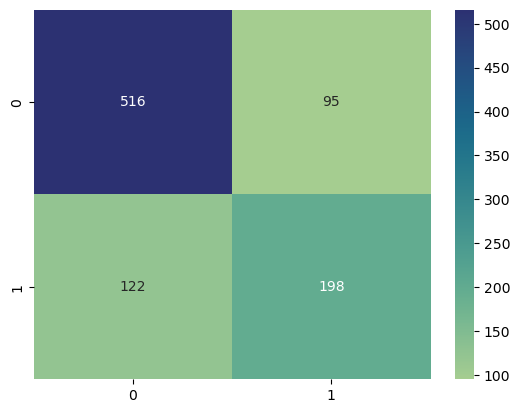

In [11]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="1", cmap="crest")
plt.show()

## Gradient Boosting

Gradient Boosting is an additive ensemble method that builds a model **sequentially**, where each new weak learner improves the previous prediction by following the **negative gradient direction** of a differentiable loss function.

### 1. Model initialization

Gradient Boosting begins with a constant prediction:

$$
F_0(x) = \arg\min_{\gamma} \sum_{i=1}^{N} L(y_i, \gamma)
$$

where  
* $L(y_i, F(x_i))$ — chosen loss function,  
* $F_0$ — initial constant estimate.

### 2. Gradient (pseudo-residual) computation

At iteration $t$, the algorithm computes the **negative gradients** of the loss function:

$$
r_i^{(t)} = - \left[
\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}
\right]_{F(x)=F_{t-1}(x)}
$$

These pseudo-residuals indicate how predictions must change to minimize the loss.

### 3. Fitting a weak learner

A regression tree is fit to approximate the residuals:

$$
h_t(x) \approx r_i^{(t)}
$$

This tree represents the direction of steepest functional descent.

### 4. Optimal leaf value / step size

For each terminal region (leaf) $R_{tj}$ of the tree, the algorithm solves:

$$
\gamma_{tj} = \arg\min_{\gamma} \sum_{x_i \in R_{tj}}
L \left( y_i,\; F_{t-1}(x_i) + \gamma \right)
$$

Each $\gamma_{tj}$ gives the optimal leaf value.

### 5. Additive model update

The model is updated using the learning rate $\eta$:

$$
F_t(x) = F_{t-1}(x) +
\eta \sum_j \gamma_{tj} \mathbf{1}(x \in R_{tj})
$$

where  
* $\eta$ — shrinkage parameter.

### 6. Final prediction

After $T$ iterations:

$$
\hat{y}(x) = F_T(x)
= F_0(x) + \sum_{t=1}^{T}
\eta \sum_j \gamma_{tj} \mathbf{1}(x \in R_{tj})
$$

### Summary

Gradient Boosting improves predictions by fitting trees to **negative gradients** of the loss.  
It provides flexibility, supports many loss functions, and serves as the conceptual basis for advanced implementations such as **XGBoost**, **LightGBM**, and **CatBoost**.

In [12]:
pipeline = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("scaler", StandardScaler(with_mean=False)),
        ("smote", SMOTE(random_state=42)),
        ("model", GradientBoostingClassifier(random_state=42))
    ]
)

In [13]:
param_grid = {
    "smote__sampling_strategy": ["auto", "not majority"],
    "model__max_depth": [3, 4, 5],
    "model__n_estimators": [200, 400, 600],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "model__subsample": [0.8, 1.0],
    "model__min_samples_leaf": [1, 3, 5]
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__n_estimators=200, model__subsample=0.8, smote__sampling_strategy=auto; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__n_estimators=200, model__subsample=0.8, smote__sampling_strategy=auto; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__n_estimators=200, model__subsample=0.8, smote__sampling_strategy=auto; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__n_estimators=200, model__subsample=0.8, smote__sampling_strategy=auto; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__n_estimators=200, model__subsample=0.8, smote__sampling_strategy=auto; total time=   0.2s
[CV] END model__learning_rate=0.01,

In [14]:
model = grid.best_estimator_
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("Classification report:")
print(classification_report(y_test, y_pred))

Accuracy: 76.69%
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       611
           1       0.68      0.62      0.65       320

    accuracy                           0.77       931
   macro avg       0.74      0.73      0.74       931
weighted avg       0.76      0.77      0.76       931



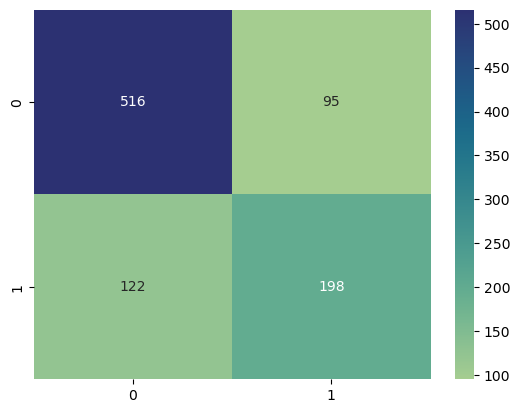

In [15]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="1", cmap="crest")
plt.show()

## XGBoost

XGBoost (Extreme Gradient Boosting) is an enhanced, regularized, and computationally optimized version of **gradient boosting**, which builds trees sequentially while using **first- and second-order derivatives**, **explicit regularization**, and advanced system optimizations.

### 1. Model initialization

XGBoost also starts from a constant model:

$$
\hat{y}_i^{(0)} = \arg\min_{c} \sum_{i=1}^{N} l(y_i, c)
$$

where  
* $l(y_i, \hat{y})$ — loss function,  
* initial output is a constant score.

### 2. Gradient and Hessian computation

At iteration $t$, XGBoost computes **both** first-order and second-order derivatives:

$$
g_i^{(t)} = \frac{\partial l(y_i, \hat{y}_i^{(t-1)})}{\partial \hat{y}_i^{(t-1)}},\qquad
h_i^{(t)} = \frac{\partial^2 l(y_i, \hat{y}_i^{(t-1)})}{\partial (\hat{y}_i^{(t-1)})^2}
$$

Unlike classical GB, XGBoost uses Hessians to build **more accurate tree approximations**.

### 3. Fitting a tree to gradients and Hessians

Instead of training on residuals, XGBoost chooses splits by maximizing the **regularized gain**:

$$
\text{Gain} =
\frac{1}{2} \left[
\frac{(\sum_{i\in L} g_i)^2}{\sum_{i\in L} h_i + \lambda}
+
\frac{(\sum_{i\in R} g_i)^2}{\sum_{i\in R} h_i + \lambda}
-
\frac{(\sum_{i\in L \cup R} g_i)^2}{\sum_{i\in L \cup R} h_i + \lambda}
\right] - \gamma
$$

where  
* $\lambda$ — L2 regularization on leaf weights,  
* $\gamma$ — penalty for creating new leaves.

### 4. Optimal leaf values

For each leaf, the optimal output is computed analytically:

$$
w_j = -\frac{\sum_{i \in I_j} g_i}{\sum_{i \in I_j} h_i + \lambda}
$$

This replaces the numeric optimization used in classical GB.

### 5. Additive model update

XGBoost adds the new tree’s output to the prediction:

$$
\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + f_t(x_i)
$$

with  
* explicit regularization,  
* advanced tree constraints (max depth, min child weight),  
* shrinkage (learning rate),  
* subsampling (rows/columns).

### 6. Objective with regularization

The full regularized objective is:

$$
\mathcal{L}^{(t)} =
\sum_{i=1}^{N} l(y_i, \hat{y}_i^{(t)}) +
\sum_{t=1}^{T}
\left( \gamma T_t + \frac{\lambda}{2} \sum_{j=1}^{T_t} w_j^2 \right)
$$

where  
* $\gamma$ and $\lambda$ reduce overfitting by penalizing model complexity.

### 7. Final prediction

After $T$ trees:

$$
\hat{y}_i = \sum_{t=0}^{T} f_t(x_i)
$$

with a final transformation applied in classification (e.g., sigmoid).

### Summary

XGBoost extends Gradient Boosting with  
* **second-order optimization (Hessians)**,  
* **explicit regularization** ($\gamma$, $\lambda$),  
* **optimized split search**,  
* **parallelization**, **sparsity handling**, **shrinkage**, **subsampling**.

It is therefore more accurate, more robust, and significantly faster than the classical algorithm while keeping the same conceptual framework of additive gradient-based tree building.

In [16]:
pipeline = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("scaler", StandardScaler(with_mean=False)),
        ("smote", SMOTE(random_state=42)),
        ("model", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1,
            tree_method="hist"
        ))
    ]
)

In [17]:
param_grid = {
    "smote__sampling_strategy": ["auto", "not majority"],
    "model__n_estimators": [200, 400],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 4, 5],
    "model__subsample": [0.7, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.9, 1.0],
    "model__reg_lambda": [1.0, 2.0, 5.0],  # L2
    "model__scale_pos_weight": [1, 2, 3, 5]
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

Fitting 10 folds for each of 2592 candidates, totalling 25920 fits
[CV] END model__colsample_bytree=0.7, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=200, model__reg_lambda=1.0, model__scale_pos_weight=1, model__subsample=0.7, smote__sampling_strategy=auto; total time=   0.0s
[CV] END model__colsample_bytree=0.7, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=200, model__reg_lambda=1.0, model__scale_pos_weight=1, model__subsample=0.7, smote__sampling_strategy=auto; total time=   0.0s
[CV] END model__colsample_bytree=0.7, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=200, model__reg_lambda=1.0, model__scale_pos_weight=1, model__subsample=0.7, smote__sampling_strategy=auto; total time=   0.0s
[CV] END model__colsample_bytree=0.7, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=200, model__reg_lambda=1.0, model__scale_pos_weight=1, model__subsample=0.7, smote__sampling_strategy=auto; total time=   0.0s
[CV] 

In [18]:
model = grid.best_estimator_
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("Classification report:")
print(classification_report(y_test, y_pred))

Accuracy: 77.55%
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       611
           1       0.70      0.62      0.65       320

    accuracy                           0.78       931
   macro avg       0.75      0.74      0.74       931
weighted avg       0.77      0.78      0.77       931



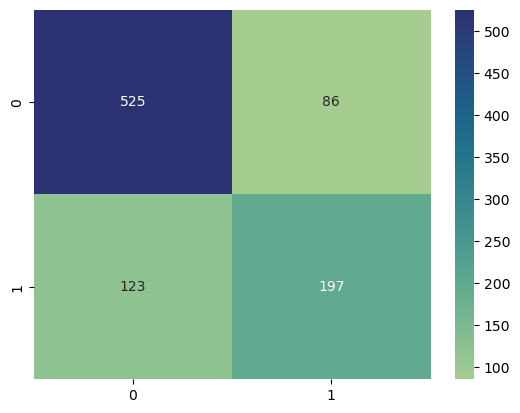

In [19]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="1", cmap="crest")
plt.show()